# Parametrized Sequence Creation: Rabi experiment & models of the Hardware

In [1]:
import numpy as np
import pulser
import pulser_simulation
from matplotlib import pyplot as plt

From simple sweeps to variational quantum algorithms, it is often the case that one wants to try out multiple pulse sequences that vary only in a few parameters. For this effect, the ability to make a `Sequence` **parametrized** was developed.

Let's here build a `Sequence` that performs a Rabi experiment, a very classical experiment in Quantum Physics that displays the probability of measuring the atoms in an excited state as a function of the integral of the amplitude of a `Pulse`. The evolution of a system of atoms far from each other under a `Pulse` having a detuning constantly equal to 0 and a phase equal to 0 was described [in the introduction to Sequence creation](./sequence_pi_pulse.ipynb). Let's here work with a single atom in the `Register`, such that no interaction between the atoms take place.

This tutorial is a simple introduction to parametrized `Sequence` and parametrized objects. All the subtleties of Parametrized Objects are presented [in an advanced notebook](../advanced_features/Parametrized%20Sequences.ipynb). 

## Creation of a Parametrized Sequence

The initialization and the declaration of channels don't change between a `Sequence` and a Parametrized `Sequence`. Let's initialize the `Sequence` with a single atom in the `Register`, and work with the `Rydberg.Global` pulse:

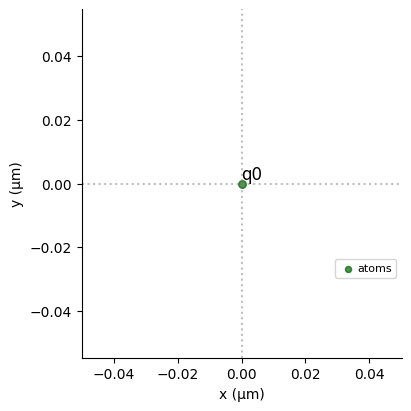

In [2]:
reg = pulser.Register.from_coordinates([(0, 0)], prefix="q")
reg.draw()
seq = pulser.Sequence(reg, pulser.AnalogDevice)
seq.declare_channel("rydberg", "rydberg_global")

### Variables

The defining characteristic of a parametrized `Sequence` is its use of **variables**. These variables are declared within a `Sequence`, by calling [`Sequence.declare_variable`](https://pulser.readthedocs.io/en/stable/apidoc/core.html#pulser.sequence.sequence.Sequence.declare_variable). For the Rabi experiment, we intend to sweep the duration of a `Pulse` of constant amplitude, so let's declare a variable duration:

In [3]:
duration = seq.declare_variable("duration", dtype=int)

The returned `duration` is a `Variable` with `dtype=int` (the default type is `float`). If you specify the size of the `Variable`, the `Variable` is an array (see [the advanced tutorial](../advanced_features/Parametrized%20Sequences.ipynb) for more details).

### Parametrized Objects and Parametrized Sequence

These `Variable` are very helpful, they can be used to perform arithmetic operations and to create Parametrized Objects in Pulser, `pulser.ParamObj`, by creating Pulser objects out of them. For instance, let's create a Parametrized Pulse of amplitude $2\pi$ rad/µs from the duration `Variable`:  

In [4]:
param_pulse = pulser.Pulse.ConstantPulse(duration, 2*np.pi, 0.0, 0.0)
type(param_pulse)

pulser.parametrized.paramobj.ParamObj

Let's now add this `Pulse` to the `Sequence`. The `Sequence` will now be considered "parametrized":  

In [5]:
seq.add(param_pulse, "rydberg")
seq.is_parametrized()

True

The `Sequence` can no longer be drawn, because the duration is not known.

## The Rabi experiment

### Building a Parametrized Sequence

Once we're happy with our parametrized sequence, the last step is to build it into a regular sequence. For that, we call the `Sequence.build()` method, in which we **must attribute values for all the declared variables**. Let's build the Parametrized Sequence with a very long duration:

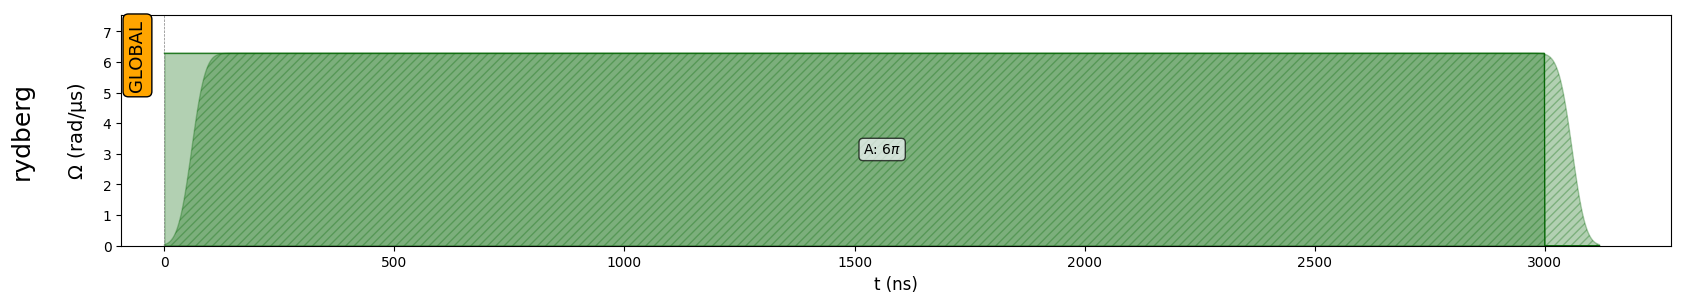

In [6]:
built_seq = seq.build(duration=3000)
built_seq.draw(draw_phase_area=True)

### Rabi oscillations

We could have plotted the final state of the simulation, but what interests us here is the evolution of the probability to measure the atom in the excited state as a function of time. This is possible with the method `SimulationResults.expect`, that can compute the probability to measure the state $\left|r\right>$ as a function of time:

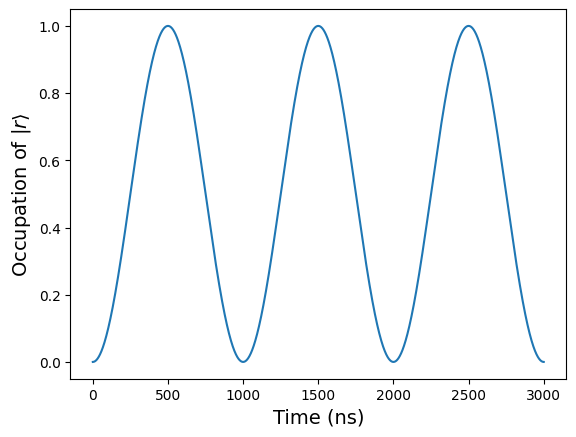

In [7]:
emulator_config = pulser.EmulatorConfig(sampling_rate=1.0, evaluation_times="Full") # default
sim = pulser_simulation.QutipBackend(built_seq, emulator_config)
res = sim.run()
# Definining the measurement operator: the projector on |r>
r = [1, 0]  # |r>
occup = [np.outer(r, np.conj(r))]  # |r><r|
proba_r = res.expect(occup)[0] # Get expectation value for the occupation operator
# Plot the expectation value as a function of time:
plt.plot(proba_r)
plt.xlabel("Time (ns)", fontsize=14)
plt.ylabel(r"Occupation of $|r\rangle$", fontsize=14)
plt.show()

Initially, the atom is in the ground-state: at $t=0$, the probability to measure the atom in state $\left|r\right>$ is 0. The pulse being of amplitude $2\pi$ rad/µs $=\frac{2\pi}{1000}$ rad/µs, the integral of the amplitude after a certain time t (in ns) is $\int_0^t \frac{2\pi}{1000} du = \frac{2\pi}{1000}t$. Therefore, at $t=500ns$, the integral of the amplitude is $\pi$ and the atom is in the excited state (as [in the introduction tutorial](sequence_pi_pulse.ipynb)), and at each multiple of $t=1000ns$, the area is a multiple of $2\pi$ so the state of the atom is back to the ground state.

The oscillations we are seing here are called the Rabi oscillations. What we see is that outside when $t=2n\pi$ and $t=\pi + 2n\pi$ (with $n$ a positive integer), where we have probability to measure state $\left|r\right>$ equal to 0 and 1 respectively, the final state is a mixture of state $\left| r\right>$ and $\left|g\right>$. For instance, for $t=\frac{\pi}{2}+2\pi$, the probability to measure the state $\left|r\right>$ is 0.5, such that the probability to measure the state $\left|g\right>$ is 0.5 as well: the qubit is in a superposition of state $\left|r\right>$ and $\left|g\right>$.

### Implementing the Rabi experiment

When using a real QPU, we can't measure the state at each nanosecond as we did with the emulator. Only measuring multiple times the final state of the atoms after the execution of the `Sequence` is possible. To reproduce the previous graph, let's execute `Sequences` having different durations, and measure each `Sequence` multiple times:  

In [8]:
# Sequence duration should be multiple of 4: step is 32
durations = range(0, 3032, 32)
# Sequence duration should be at least 16: first value is 0
exp_proba_r = [0]
# Since we only want to get the final state, evalution times is set to "Minimal"
fast_config = pulser.EmulatorConfig(sampling_rate=1.0, evaluation_times="Minimal")
# Each Sequence is measured 1000 times
N_samples=1000 

for t in durations[1:]:
    # Building the Sequence
    built_seq = seq.build(duration=t)

    sim = pulser_simulation.QutipBackend(built_seq, fast_config)
    res = sim.run()
    final_state = res.sample_final_state(N_samples=N_samples)
    exp_proba_r.append(final_state["1"]/N_samples)

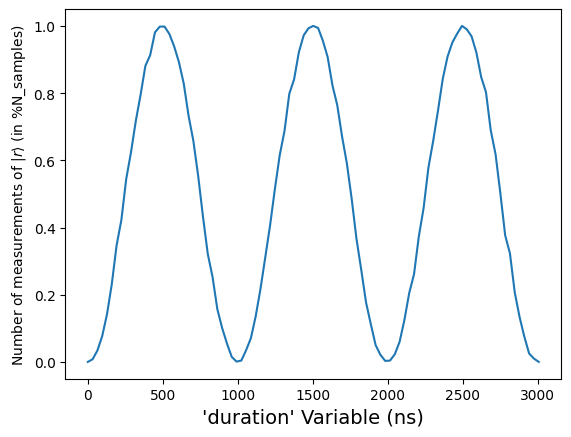

In [9]:
# Plot the expectation value as a function of duration:
plt.plot(durations, exp_proba_r)
plt.xlabel("'duration' Variable (ns)", fontsize=14)
plt.ylabel(r"Number of measurements of $|r\rangle$ (in %N_samples)", fontsize=10)
plt.show()

The obtained curve, that represent the statistics of the measurement of state $\left|r\right>$ for different durations value, follows the same behaviour as the probability to measure the final state in state $\left|r\right>$. This is the effect of measurement: if a state is a mixture of states, the number of times the final state in expected to be measured in the state $\left|i\right>$ when performing $N$ measurements is approximatively $N p_i$, with $p_i$ the probability to measure state $\left|i\right>$.

## Hardware models vs Theory

So far, we have always worked with a perfect model for our hardware: we have always expected our hardware to behave exactly the way it is programmed. This is not exactly true, and this can have a huge influence on our Analog computations, since we might not do exactly the operation that was expected.

There are two key differences between the theoretical behaviour and the real one:
- The `Pulse` go through some optical elements named **AOM** (Acousto-Optic Modulator), that modulates the light of the incoming laser by a gaussian of frequency `Channel.modulation_bandwidth`. This modifies the shape of the `Pulse` applied on the atoms.
- The atoms during the simulation experience some external noise, coming from various source. This can cause state preparation and measurement errors (SPAM errors), or modify the amplitude and detuning experienced by each atoms locally. These noises are provided with each QPU in `Device.default_noise_model`.

The Rabi experiment is a great tool to expose the issues associated with the `NoiseModel` and the effect of the various noises. This is further explained using Rabi experiments in the [classical simulation section](../classical_simulation/Simulating%20Sequences%20with%20Errors%20and%20Noise.ipynb). 

The effect of **Modulation** can be presented with constant waveforms: let's investigate the effect of **Modulation**, and briefly introduce **EOM** as a way to mitigate the issues that might arise. These two concepts are further detailed [in an advanced tutorial](../advanced_features/Output%20Modulation%20and%20EOM%20Mode.ipynb).

### Effect of Modulation

The `Rydberg.Global` channel in `pulser.AnalogDevice` has a modulation bandwidth. This modulation bandwidth is the source of the modification of the pulse's shape when the `Pulse`'s shape vary. For instance, in the previous experiment, the shape of the `Pulse` is modified at the beginning and the end of the `Pulse`. This can be seen by drawing the `Sequence`: the modulated `Sequence` appears in hashed lines: 

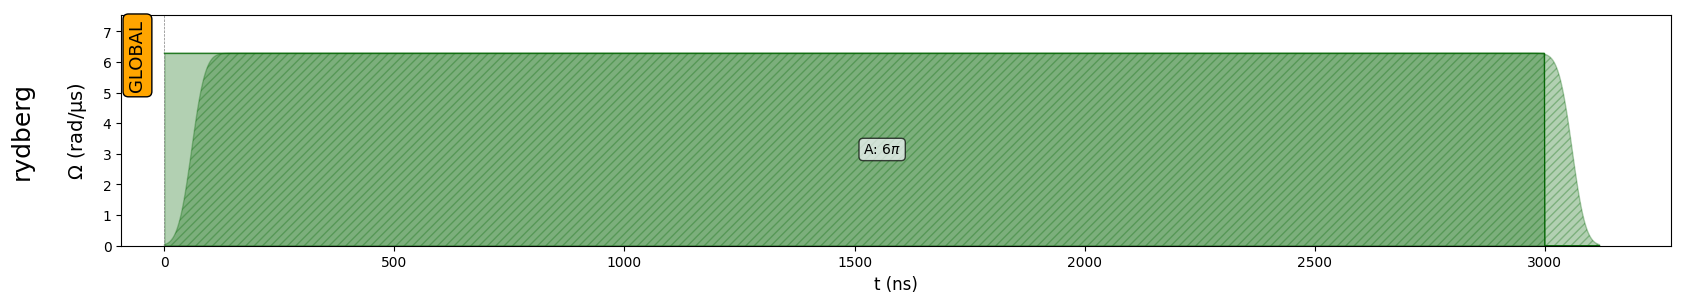

Integral of the modulated sequence (hashed line area) is: 5.999999999999999 π.


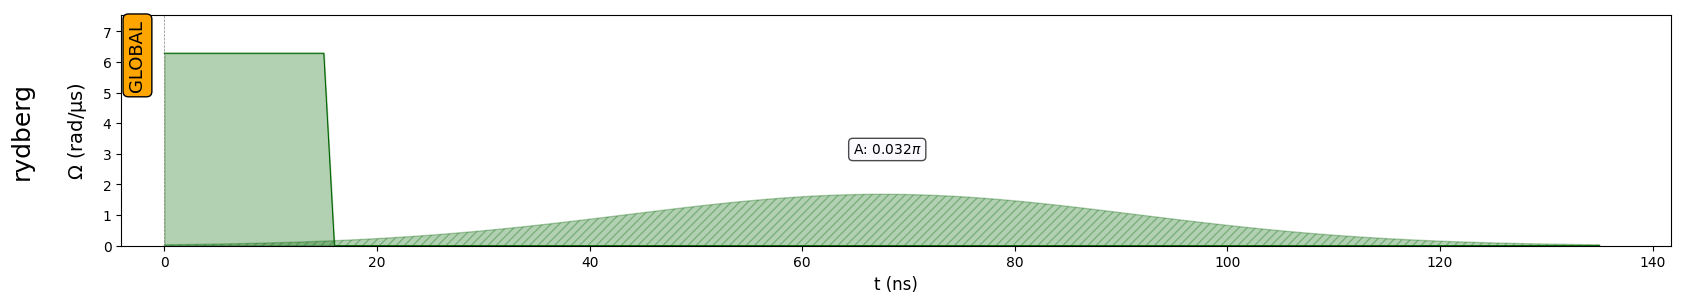

Integral of the modulated sequence (hashed line area) is: 0.032 π.


In [10]:
long_sequence = seq.build(duration=3000)
long_sequence.draw(draw_phase_area=True)
print(
    "Integral of the modulated sequence (hashed line area) is:",
    float(np.sum(pulser.sampler.sample(long_sequence, modulation=True).channel_samples["rydberg"].amp)) * 1e-3/np.pi,
    "π."
)
short_sequence = seq.build(duration=16)
short_sequence.draw(draw_phase_area=True)
print(
    "Integral of the modulated sequence (hashed line area) is:",
    float(np.sum(pulser.sampler.sample(short_sequence, modulation=True).channel_samples["rydberg"].amp)) * 1e-3/np.pi,
    "π."
)

As you can see, the modulation modifies the shape of the `Waveforms`. However, the integral of the `Pulses` is not impacted, hence this effect has a minimal effect on the final state of the atoms after such a `Pulse`, which can be reflected by looking at a Rabi oscillation: 

In [11]:
# Sequence duration should be multiple of 4: step is 32
# Sequence duration should be at least 16: starts at 16
mod_durations = range(16, 1000, 16)
mod_proba_r = []
exp_proba_r = []
# Since we only want to get the final state, evalution times is set to "Minimal"
mod_config = pulser.EmulatorConfig(sampling_rate=1.0, evaluation_times="Minimal", with_modulation=True)

for t in mod_durations:
    # Building the Sequence
    built_seq = seq.build(duration=t)

    mod_res = pulser_simulation.QutipBackend(built_seq, mod_config).run()
    mod_final_state = mod_res.get_final_state()
    mod_proba_r.append(abs(mod_final_state[0][0][0])**2)

    res = pulser_simulation.QutipBackend(built_seq, fast_config).run()
    final_state = res.get_final_state()
    exp_proba_r.append(abs(final_state[0][0][0])**2)

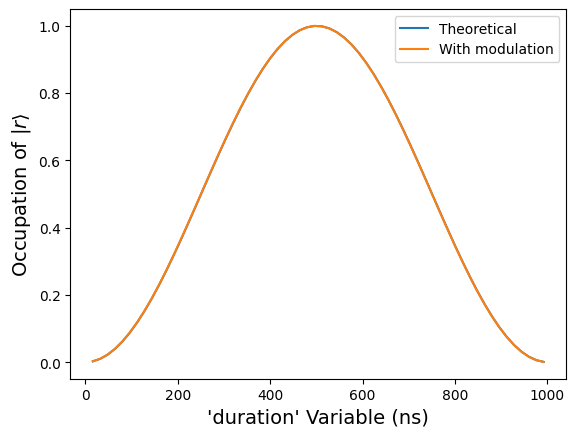

In [12]:
# Plot the expectation value as a function of duration:
plt.plot(mod_durations, exp_proba_r, label="Theoretical")
plt.plot(mod_durations, mod_proba_r, label="With modulation")
plt.xlabel("'duration' Variable (ns)", fontsize=14)
plt.ylabel(r"Occupation of $|r\rangle$", fontsize=14)
plt.legend()
plt.show()

However, this means you have to be extremely cautious if you want to have two constant `Pulses` separated by a short delay. Let's take the example of Ramsey interferometry, where two $\frac{\pi}{2}$-pulse are added one after the other:

c:\users\antoinecornillot\onedrive - pasqal sas\documents\pulser-fork2\pulser\pulser-core\pulser\sequence\sequence.py:1443: UserWarning: A duration of 250 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 252 ns.
  self._add(pulse, channel, protocol)


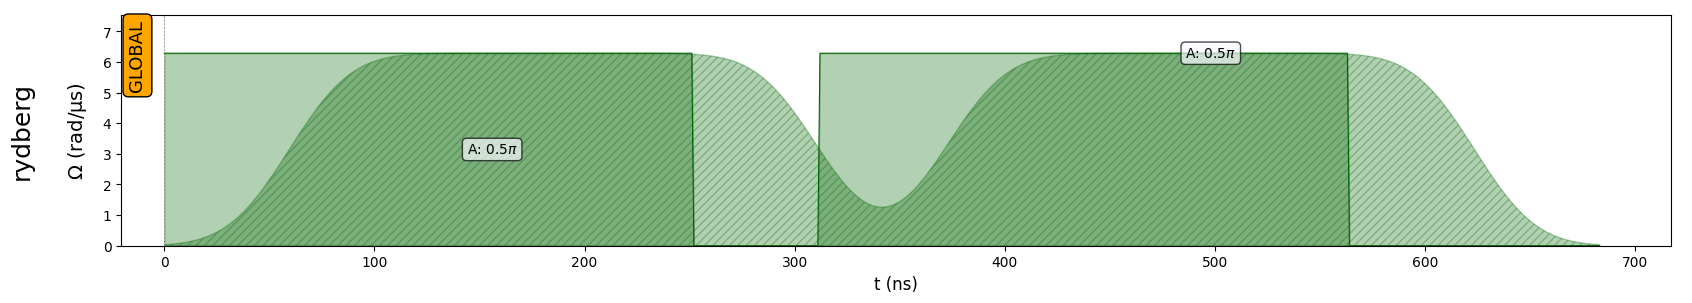

Integral of the sequence is: 1.008 π.
Integral of the modulated sequence (hashed line area) is: 1.008 π.


In [13]:
ramsey_seq = seq.build(duration=250)  # a pi/2-pulse
ramsey_seq.delay(60, "rydberg")
ramsey_seq.add(pulser.Pulse.ConstantPulse(250, 2*np.pi, 0, 0), "rydberg") # another pi/2-pulse
ramsey_seq.draw(draw_phase_area=True)
print(
    "Integral of the sequence is:",
    float(np.sum(pulser.sampler.sample(ramsey_seq, modulation=False).channel_samples["rydberg"].amp)) * 1e-3/np.pi,
    "π."
)
print(
    "Integral of the modulated sequence (hashed line area) is:",
    float(np.sum(pulser.sampler.sample(ramsey_seq, modulation=True).channel_samples["rydberg"].amp)) * 1e-3/np.pi,
    "π."
)

In the modulated `Sequence`, there is no longer a time during which there is no amplitude applied. However, the integral of the amplitude of the `Pulse` is the same, so the final state is unchanged. 

As a conclusion, the main issue with modulation is that it extends the duration of all the wavelengths:
- This is an issue for very long `Pulses`, such as in the Rabi experiment. Indeed, it restricts the maximum duration a `Pulse` can be, for the atoms to receive light (the modulated `Pulse`) while still being coherent (the relaxation time of the `NoiseModel`, see [the tutorials on noise](../classical_simulation/Simulating%20Sequences%20with%20Errors%20and%20Noise.ipynb)) or for the duration of the modulated light being shorted than the maximum duration a `Channel` can be. Pulser handles the latter by estimating the duration of each modulated `Pulse` added to a `Channel` and ensuring the final duration of the `Sequence` will match the maximum duration of this `Channel`.
- This is an issue if you have a `Sequence` of `Pulses` with amplitude and detunings: if a first `Pulse` has a detuning, it might still be on during a second `Pulse` that was not subject to have some. If needed, Pulser handles the modulation in `delays` by taking extra delay times between two `Pulses` that might conflict (just set the option `at_rest` to `True` in `Sequence.delay`). You can read about this [in the advanced tutorial](../advanced_features/Output%20Modulation%20and%20EOM%20Mode.ipynb).

To tackle these issues, it is possible to use a different optical element with which the modulation effect is diminished. This optical element is the **EOM** (Electro-optic Modulator), that can be used using `Sequence.enable_eom_mode`. The only issue with these optical elements is that only constant pulses can be applied on them. A first use case is that it can enable to perform a longer Rabi experiment:

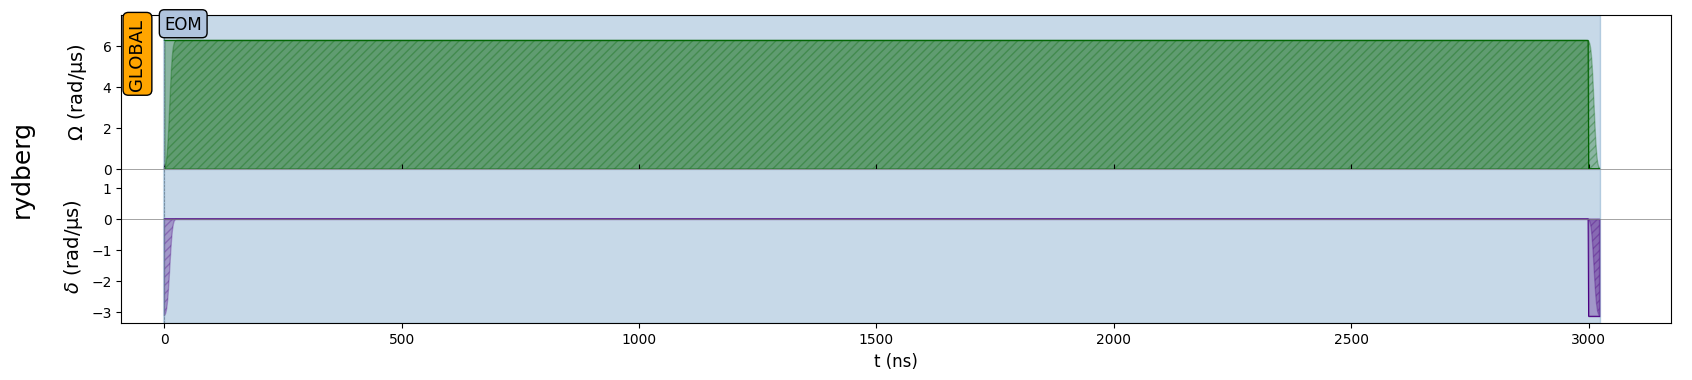

In [14]:
rabi_eom_seq = pulser.Sequence(reg, pulser.AnalogDevice)
rabi_eom_seq.declare_channel("rydberg", "rydberg_global")
duration = rabi_eom_seq.declare_variable("duration", dtype=int)
rabi_eom_seq.enable_eom_mode("rydberg", amp_on=2*np.pi, detuning_on=0.0)
rabi_eom_seq.add_eom_pulse("rydberg", duration, 0.0)

long_eom_seq = rabi_eom_seq.build(duration=3000)
long_eom_seq.draw()

We can also rewrite the Ramsey Sequence built above with EOM:

Modulation Bandwidth of the AOM of the Rydberg.Global in AnalogDevice: 8
Modulation Bandwidth of the EOM of the Rydberg.Global in AnalogDevice: 40


c:\users\antoinecornillot\onedrive - pasqal sas\documents\pulser-fork2\pulser\pulser-core\pulser\sequence\sequence.py:1395: UserWarning: A duration of 250 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 252 ns.
  self._add(


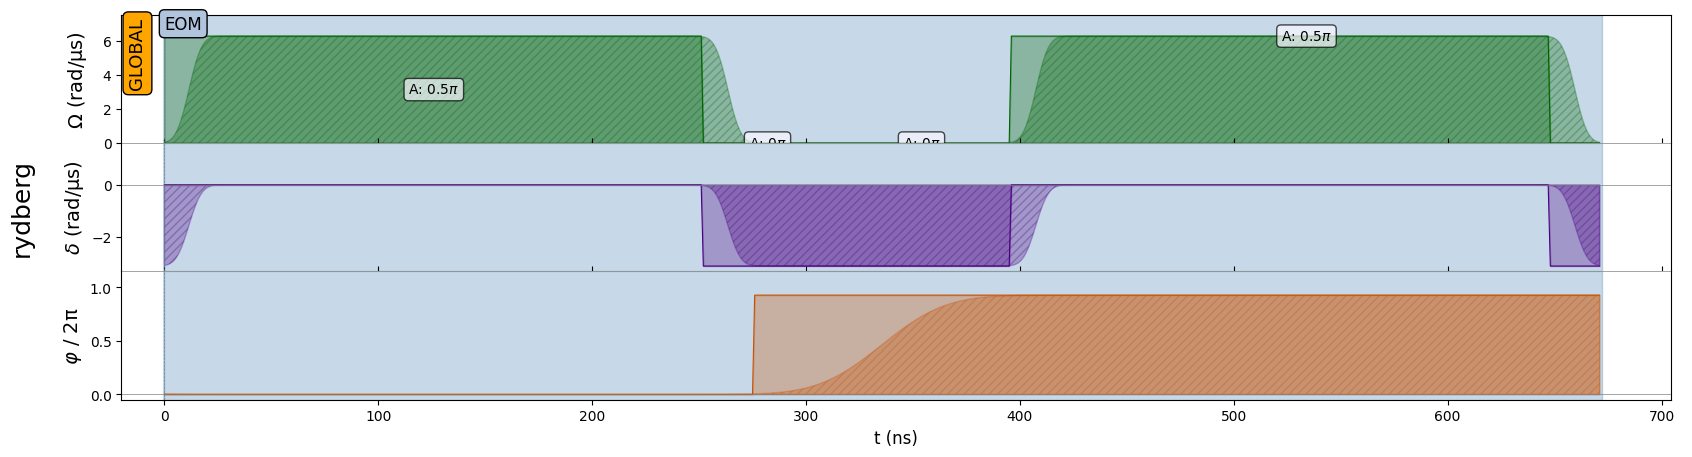

In [15]:
print("Modulation Bandwidth of the AOM of the Rydberg.Global in AnalogDevice:", pulser.AnalogDevice.channels["rydberg_global"].mod_bandwidth)
print("Modulation Bandwidth of the EOM of the Rydberg.Global in AnalogDevice:", pulser.AnalogDevice.channels["rydberg_global"].eom_config.mod_bandwidth)
# Long modulation bandwidth => Faster modulation
# Creating the Sequence:
eom_seq = pulser.Sequence(reg, pulser.AnalogDevice)
eom_seq.declare_channel("rydberg", "rydberg_global")
# Only pulses of amplitude 2pi and detuning 0 will be added
eom_seq.enable_eom_mode('rydberg', amp_on=2*np.pi, detuning_on=0.0)
eom_seq.add_eom_pulse("rydberg", duration=250, phase=0.)  # first pi/2 pulse
eom_seq.delay(60, "rydberg")
eom_seq.add_eom_pulse("rydberg", duration=250, phase=0., correct_phase_drift=True)  # second pi/2 pulse
eom_seq.draw(draw_phase_area=True, draw_phase_curve=True)

As you can see, the value of the amplitude and detuning of the modulated `Sequence` is closer to the theoretical one compared to the `Sequence` built with AOMs. This comes from the modulation bandwidth of the EOM being higher than the modulation bandwidth of the AOM: the time taken by the EOM to rise to the maximum value is thus smaller than the rise-time of the AOM.

One of the complexity with EOMs is that they induce detuned delays in between two EOM `Pulses`. This modifies the state of the atom (see Ramsey interferometry), but we can play with the detuning to cancel the impact of this detuning. This is what we do when setting the option `correct_phase_drift` to `True` in the second `Pulse` after the delay.

It also induces some modulated detuning to overlap with the modulated amplitude. In practice, this is not a big issue since the detuning decreases as the amplitude increases, such that the overlap is minimal. We can check that the two final states are very close to each other:

In [16]:
ramsey_sim = pulser_simulation.QutipBackend(ramsey_seq, fast_config)
ramsey_res = ramsey_sim.run()
ramsey_final_state = ramsey_res.get_final_state()
print("Final state obtained with theoretical AOM Sequence:", ramsey_final_state)
mod_ramsey_sim = pulser_simulation.QutipBackend(ramsey_seq, mod_config)
mod_ramsey_res = mod_ramsey_sim.run()
mod_ramsey_final_state = mod_ramsey_res.get_final_state()
print("Final state obtained with modulated AOM Sequence:", mod_ramsey_final_state)
eom_sim = pulser_simulation.QutipBackend(eom_seq, fast_config)
eom_res = eom_sim.run()
eom_final_state = eom_res.get_final_state()
print("Final state obtained with theoretical EOM Sequence:", eom_final_state)
mod_eom_sim = pulser_simulation.QutipBackend(eom_seq, mod_config)
mod_eom_res = mod_eom_sim.run()
mod_eom_final_state = mod_eom_res.get_final_state()
print("Final state obtained with modulated Sequence:", mod_eom_final_state)

Final state obtained with theoretical AOM Sequence: Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.99993569+0.j        ]
 [0.        -0.01134081j]]
Final state obtained with modulated AOM Sequence: Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.99992415+0.j        ]
 [0.        -0.01231603j]]
Final state obtained with theoretical EOM Sequence: Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.99993581+0.j        ]
 [0.00496695-0.01018397j]]
Final state obtained with modulated Sequence: Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.99992179+0.j        ]
 [0.00586589-0.01104516j]]


Conclusion: The **EOM** is a good tool to implement custom waveforms closer to their theoretical shape. To have a complete overview over the **EOM**, you can have a look [to the advanced tutorial on Output Modulation and EOM mode](../advanced_features/Output%20Modulation%20and%20EOM%20Mode.ipynb).